In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from dataprep.clean import clean_country
from plotly.subplots import make_subplots
import dask.dataframe as dd

In [3]:
co2_file_path = "./dataset/owid-co2-data.csv"
co2_df = pd.read_csv(co2_file_path)

In [4]:
# dask is cool with huge csvs
csv_file_path = "/home/amir/big_storage/datasets/IHME-GDB-Risk-all.csv"

risk_df= pd.read_csv(csv_file_path)
risk_df = clean_country(risk_df, 'location', output_format='alpha-3')

  0%|          | 0/91 [00:00<?, ?it/s]

Country Cleaning Report:
	2741220 values cleaned (99.37%)
	17460 values unable to be parsed (0.63%), set to NaN
Result contains 2741220 (99.37%) values in the correct format and 17460 null values (0.63%)


In [133]:
risk_df.head()

,measure,location,sex,age,cause,rei,metric,year,val,upper,lower,location_clean
0,YLDs,Norway,Male,All Ages,Depressive disorders,All risk factors,Number,1992,576.937291,1074.430283,241.176114,NOR
1,YLDs,Norway,Female,All Ages,Depressive disorders,All risk factors,Number,1992,1831.591888,3294.474095,665.732721,NOR
2,YLDs,Norway,Both,All Ages,Depressive disorders,All risk factors,Number,1992,2408.529178,4122.109930,974.516636,NOR
3,YLDs,Norway,Male,All Ages,Depressive disorders,All risk factors,Rate,1992,27.241200,50.731285,11.387593,NOR
4,YLDs,Norway,Female,All Ages,Depressive disorders,All risk factors,Rate,1992,84.472852,151.940847,30.703533,NOR


In [5]:
cause_list = [
    "Depressive disorders",
    "Cardiovascular diseases",
    "Chronic respiratory diseases",
    "Neurological disorders",
    "Tracheal, bronchus, and lung cancer",
    "Stomach cancer",
    "Pancreatic cancer",
    "Leukemia",
    "Esophageal cancer",
    "Larynx cancer",
    "Colon and rectum cancer",
    "Liver cancer",
    "Other non-communicable diseases",
]

# cause_list = [
#     "All causes"
# ]


In [8]:

cause_df = risk_df[
    risk_df.cause.isin(cause_list)
    & (risk_df.metric == "Rate")
    & (risk_df.measure == "Deaths")
    & (risk_df.sex == "Both")
    # & (risk_df.year >= 2000)
].sort_values("year").reset_index(drop=True)
cause_df.head()

,measure,location,sex,age,cause,rei,metric,year,val,upper,lower,location_clean
0,Deaths,Lao People's Democratic Republic,Both,All Ages,Stomach cancer,All risk factors,Rate,1990,2.141225,3.986941,1.197598,LAO
1,Deaths,Lao People's Democratic Republic,Both,All Ages,Neurological disorders,All risk factors,Rate,1990,1.201337,3.796150,0.166485,LAO
2,Deaths,Oman,Both,All Ages,Other non-communicable diseases,Particulate matter pollution,Rate,1990,0.015407,0.045529,0.002352,OMN
3,Deaths,Oman,Both,All Ages,Other non-communicable diseases,All risk factors,Rate,1990,0.071865,0.185637,0.012971,OMN
4,Deaths,Oman,Both,All Ages,Other non-communicable diseases,Air pollution,Rate,1990,0.015407,0.045529,0.002352,OMN


In [9]:
co2_df = co2_df[co2_df.year.between(cause_df.year.min(), cause_df.year.max())]
co2_df[co2_df.iso_code=="USA"]

,iso_code,country,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
24037,USA,United States,1990,5113.455,5031.786,-0.36,-18.472,-81.669,20.282,19.958,...,22.488,798.61,3.168,254.99,1.011,252120309.0,9.250378e+12,22498.158,89235.912,2.432
24038,USA,United States,1991,5057.931,4949.136,-1.09,-55.524,-108.795,19.871,19.444,...,22.110,801.89,3.150,256.20,1.007,254539371.0,9.243499e+12,22466.677,88264.181,2.431
24039,USA,United States,1992,5167.481,5134.515,2.17,109.550,-32.966,20.108,19.979,...,22.215,800.73,3.116,261.95,1.019,256990608.0,9.572148e+12,22803.378,88732.202,2.383
24040,USA,United States,1993,5267.343,5194.300,1.93,99.862,-73.043,20.296,20.014,...,22.422,783.55,3.019,269.35,1.038,259532130.0,9.834941e+12,23279.396,89697.594,2.366
24041,USA,United States,1994,5358.824,5295.360,1.74,91.481,-63.464,20.435,20.193,...,22.522,790.58,3.015,273.36,1.042,262241204.0,1.023202e+13,23712.755,90423.527,2.325
24042,USA,United States,1995,5421.502,5356.474,1.17,62.678,-65.028,20.446,20.201,...,22.517,777.91,2.934,278.99,1.052,265163740.0,1.051026e+13,24222.295,91348.356,2.307
24043,USA,United States,1996,5610.582,5526.463,3.49,189.079,-84.119,20.909,20.595,...,22.618,754.68,2.812,282.97,1.055,268335007.0,1.090917e+13,25035.434,93299.171,2.297
24044,USA,United States,1997,5686.465,5632.188,1.35,75.883,-54.277,20.928,20.728,...,23.196,734.60,2.704,275.64,1.014,271713634.0,1.139876e+13,25225.640,92838.946,2.213
24045,USA,United States,1998,5731.050,5795.627,0.78,44.585,64.578,20.827,21.062,...,23.060,717.39,2.607,272.74,0.991,275175309.0,1.190603e+13,25391.342,92273.429,2.134
24046,USA,United States,1999,5804.669,5961.355,1.28,73.619,156.686,20.839,21.402,...,22.853,708.26,2.543,268.40,0.964,278548148.0,1.246382e+13,25840.805,92769.666,2.067


In [10]:
def get_all_vs_air(df, cause=None):
    result_df = [
        df,  # all
        df,  # air
    ]
    for index, poll in enumerate(["All risk factors", "Air pollution"]):
        temp = result_df[index]
        temp = temp[temp.rei == poll]
        if cause:
            temp = temp[temp.cause == cause]
        result_df[index] = temp
    # air_global_df = global_df[global_df.rei == ]
    # all_global_df = global_df[global_df.rei == ]
    
    for index, temp_df in enumerate(result_df):

        result_df[index] = temp_df.groupby("year").agg(
            val = ('val', 'sum')
        ).reset_index()

    # air_global_df = air_global_df.groupby("year").agg(
    #     val = ('val', 'sum')
    # ).reset_index()

    return result_df


In [11]:
specific_cases = [
    None, # scan all
    "Chronic respiratory diseases",
    "Cardiovascular diseases",
]

In [12]:
# fig = px.line(air_global_df, x="year", y="val")
# Create tracesfrom plotly.subplots import make_subplots
def draw_plot(df, co2, where):
    fig = make_subplots(
        rows=len(specific_cases)+1, cols=1, shared_xaxes=True, x_title="year", y_title="Rate (per 100,000)",
        subplot_titles=[i if i else "All Causes" for i in specific_cases ].append("Co2 per Capita")
    )
    # fig = go.Figure()

    for row, cause in enumerate(specific_cases):
        all_risk_df, air_risk_df = get_all_vs_air(df, cause)

        fig.add_trace(
            go.Scatter(
                x=all_risk_df.year,
                y=all_risk_df.val,
                mode="lines+markers",
                name="All Risk Factor",
            ),
            row=row + 1,
            col=1,
        )
        fig.add_trace(
            go.Scatter(
                x=air_risk_df.year,
                y=air_risk_df.val,
                mode="lines+markers",
                name="Air Pollution",
            ),
            row=row + 1,
            col=1,
        )
    last_row = len(specific_cases)+1

    fig.add_trace(
        go.Scatter(
            x=co2.year,
            y=co2.co2_per_capita,
            mode="lines",
            name="co2 per capita",
        ),
        row=last_row,
        col=1,
    )


    fig.update_layout(
        title=f"Compare Death rate for <b>All Risk Factor</b> vs <b>Air Pollution</b> over the years 1990 to 2019<br>{where}",
        legend_title="Risk Factor",
    )
    fig["layout"]["hovermode"] = "x"
    return fig


In [13]:
global_df = cause_df[cause_df.location == "Global"]
co2_world = co2_df[co2_df.country=="World"]
draw_plot(global_df, co2_world, "Global" )

In [14]:
china_df = cause_df[cause_df.location_clean=="CHN"]
co2 = co2_df[co2_df.iso_code=="CHN"]
draw_plot(china_df,co2, where="China")

In [15]:

iran_df = cause_df[cause_df.location_clean=="IRN"]
co2 = co2_df[co2_df.iso_code=="IRN"]
draw_plot(iran_df, co2, "Iran")

In [16]:

df = cause_df[cause_df.location_clean=="IND"]
co2 = co2_df[co2_df.iso_code=="IND"]
draw_plot(iran_df, co2, "India")

In [17]:

iso_code = "USA"
df = cause_df[cause_df.location_clean=="USA"]
co2 = co2_df[co2_df.iso_code=="USA"]
draw_plot(iran_df, co2, iso_code)

In [18]:
co2

,iso_code,country,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
24037,USA,United States,1990,5113.455,5031.786,-0.36,-18.472,-81.669,20.282,19.958,...,22.488,798.61,3.168,254.99,1.011,252120309.0,9.250378e+12,22498.158,89235.912,2.432
24038,USA,United States,1991,5057.931,4949.136,-1.09,-55.524,-108.795,19.871,19.444,...,22.110,801.89,3.150,256.20,1.007,254539371.0,9.243499e+12,22466.677,88264.181,2.431
24039,USA,United States,1992,5167.481,5134.515,2.17,109.550,-32.966,20.108,19.979,...,22.215,800.73,3.116,261.95,1.019,256990608.0,9.572148e+12,22803.378,88732.202,2.383
24040,USA,United States,1993,5267.343,5194.300,1.93,99.862,-73.043,20.296,20.014,...,22.422,783.55,3.019,269.35,1.038,259532130.0,9.834941e+12,23279.396,89697.594,2.366
24041,USA,United States,1994,5358.824,5295.360,1.74,91.481,-63.464,20.435,20.193,...,22.522,790.58,3.015,273.36,1.042,262241204.0,1.023202e+13,23712.755,90423.527,2.325
24042,USA,United States,1995,5421.502,5356.474,1.17,62.678,-65.028,20.446,20.201,...,22.517,777.91,2.934,278.99,1.052,265163740.0,1.051026e+13,24222.295,91348.356,2.307
24043,USA,United States,1996,5610.582,5526.463,3.49,189.079,-84.119,20.909,20.595,...,22.618,754.68,2.812,282.97,1.055,268335007.0,1.090917e+13,25035.434,93299.171,2.297
24044,USA,United States,1997,5686.465,5632.188,1.35,75.883,-54.277,20.928,20.728,...,23.196,734.60,2.704,275.64,1.014,271713634.0,1.139876e+13,25225.640,92838.946,2.213
24045,USA,United States,1998,5731.050,5795.627,0.78,44.585,64.578,20.827,21.062,...,23.060,717.39,2.607,272.74,0.991,275175309.0,1.190603e+13,25391.342,92273.429,2.134
24046,USA,United States,1999,5804.669,5961.355,1.28,73.619,156.686,20.839,21.402,...,22.853,708.26,2.543,268.40,0.964,278548148.0,1.246382e+13,25840.805,92769.666,2.067


In [19]:
cause_df.head()

,measure,location,sex,age,cause,rei,metric,year,val,upper,lower,location_clean
0,Deaths,Lao People's Democratic Republic,Both,All Ages,Stomach cancer,All risk factors,Rate,1990,2.141225,3.986941,1.197598,LAO
1,Deaths,Lao People's Democratic Republic,Both,All Ages,Neurological disorders,All risk factors,Rate,1990,1.201337,3.796150,0.166485,LAO
2,Deaths,Oman,Both,All Ages,Other non-communicable diseases,Particulate matter pollution,Rate,1990,0.015407,0.045529,0.002352,OMN
3,Deaths,Oman,Both,All Ages,Other non-communicable diseases,All risk factors,Rate,1990,0.071865,0.185637,0.012971,OMN
4,Deaths,Oman,Both,All Ages,Other non-communicable diseases,Air pollution,Rate,1990,0.015407,0.045529,0.002352,OMN


In [109]:
x = cause_df[cause_df.rei=="Air pollution"].groupby(['location_clean', 'year']).agg(
    val=('val', 'mean')
).reset_index()
x = x.rename({"location_clean": "iso_code"}, axis=1)
x.head()

,iso_code,year,val
0,AFG,1990,42.032542
1,AFG,1991,38.573435
2,AFG,1992,34.110325
3,AFG,1993,31.944524
4,AFG,1994,31.411907


In [110]:
co2_to_merge = co2_df[["iso_code","year", "co2_per_capita"]]

In [140]:
pm25 = pd.read_csv("./dataset/pollution_pm25.csv")
ozone = pd.read_csv("./dataset/pollution_ozone.csv")

In [141]:
pm25 = pm25[pm25.Type=="country"].rename({"ISO3": "iso_code", "Year": "year", "Exposure Mean": "pm25_exposure"}, axis=1)
pm25 = pm25[['iso_code', 'year', 'pm25_exposure']] 
pm25.head()

,iso_code,year,pm25_exposure
0,AFG,1990,49.3
1,AFG,1995,48.6
2,AFG,2000,51.6
3,AFG,2005,46.2
4,AFG,2010,51.8


In [142]:
ozone = ozone[ozone.Type=="country"].rename({"ISO3": "iso_code", "Year": "year", "Exposure Mean": "ozone_exposure"}, axis=1)
ozone = ozone[['iso_code', 'year', 'ozone_exposure']]
ozone.head()

,iso_code,year,ozone_exposure
0,AFG,1990,56.6
1,AFG,1995,54.7
2,AFG,2000,56.3
3,AFG,2005,53.6
4,AFG,2010,53.0


In [160]:
poll = pd.merge(pm25, ozone, on=['iso_code', 'year'])
poll.head()

,iso_code,year,pm25_exposure,ozone_exposure
0,AFG,1990,49.3,56.6
1,AFG,1995,48.6,54.7
2,AFG,2000,51.6,56.3
3,AFG,2005,46.2,53.6
4,AFG,2010,51.8,53.0


In [163]:
fossil = pd.read_csv('./dataset/fossil-fuel-consumption-per-capita.csv')
fossil.head()

,Entity,Code,Year,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
0,Africa,NaN,1965,1010.462,1017.972,29.811
1,Africa,NaN,1966,984.358,1086.678,32.505
2,Africa,NaN,1967,981.169,1051.101,31.327
3,Africa,NaN,1968,994.883,1081.425,30.957
4,Africa,NaN,1969,978.624,1068.662,35.267


In [171]:
fossil = fossil.rename({"Code": "iso_code", "Year": "year"}, axis=1).drop("Entity", axis=1)
fossil.head()

,iso_code,year,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
0,NaN,1965,1010.462,1017.972,29.811
1,NaN,1966,984.358,1086.678,32.505
2,NaN,1967,981.169,1051.101,31.327
3,NaN,1968,994.883,1081.425,30.957
4,NaN,1969,978.624,1068.662,35.267


In [173]:
poll = pd.merge(poll, fossil, on=['iso_code', 'year'])

In [231]:
# dataset = pd.merge(x, co2_to_merge, on=['iso_code', 'year'])
dataset = pd.merge(x, poll, on=['iso_code', 'year'])
dataset.head()

,iso_code,year,val,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
0,ARE,1990,6.429873,43.7,57.9,0.000,99642.132,90192.906
1,ARE,1995,6.867604,43.5,56.7,0.000,101689.557,100083.931
2,ARE,2000,6.482397,43.6,63.0,0.000,74163.656,97780.072
3,ARE,2005,5.935968,43.2,59.2,368.642,64637.917,89360.904
4,ARE,2010,4.130418,43.5,58.0,895.067,43742.978,69323.616


In [232]:
# lets fix these
dataset[dataset.isna().any(axis=1)]

,iso_code,year,val,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)


In [233]:
# dataset = dataset[dataset.iso_code!="PRI"]
# dataset = dataset.fillna(method='backfill')
dataset.iloc[:, 3:]

,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
0,43.7,57.9,0.000,99642.132,90192.906
1,43.5,56.7,0.000,101689.557,100083.931
2,43.6,63.0,0.000,74163.656,97780.072
3,43.2,59.2,368.642,64637.917,89360.904
4,43.5,58.0,895.067,43742.978,69323.616
...,...,...,...,...,...
1045,29.2,37.1,17630.603,6009.058,779.733
1046,28.7,37.3,18681.591,5584.721,809.305
1047,28.9,39.2,18118.674,5487.286,777.792
1048,28.8,39.6,18074.562,5551.504,773.954


In [234]:
dataset.iloc[:,2]

0       6.429873
1       6.867604
2       6.482397
3       5.935968
4       4.130418
          ...   
1045    8.802078
1046    8.674023
1047    8.492356
1048    7.869987
1049    7.627827
Name: val, Length: 1050, dtype: float64

In [235]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [236]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.iloc[:, 3:],
    dataset.iloc[:, 2],
    test_size=0.2,
    random_state=109,
)


In [247]:
from sklearn.decomposition import PCA as sklearnPCA
pca = sklearnPCA(n_components=3) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X_train))

In [256]:
X_norm = (X_train - X_train.min())/(X_train.max() - X_train.min())
X_test_norm = (X_test - X_test.min())/(X_test.max() - X_test.min())
X_norm.head()

,pm25_exposure,ozone_exposure,Coal per capita (kWh),Oil per capita (kWh),Gas per capita (kWh)
392,0.231710,0.577878,0.047029,0.073822,0.019620
819,0.124972,0.345372,0.081098,0.030505,0.020867
999,0.401823,0.577878,0.010468,0.007916,0.060002
322,0.051701,0.257336,0.988994,0.173753,0.033349
478,0.507449,0.792325,0.000000,0.072220,0.004676


In [252]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
  
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
  
# fit the regressor with x and y data
regressor.fit(X_norm, y_train) 

RandomForestRegressor(random_state=0)

In [265]:
y_pred = regressor.predict(X_test_norm)

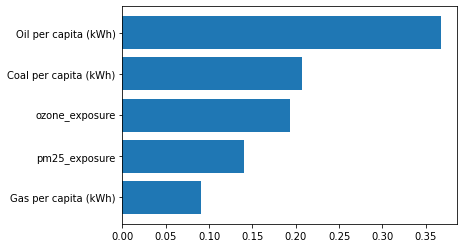

In [271]:
f_i = list(zip(X_norm.columns,regressor.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.show()

In [278]:
from sklearn.metrics import confusion_matrix
regressor.score(X_test, list(y_test))
# matrix = confusion_matrix(y_test, y_pred)
# print(matrix)

-0.4662394743625504

In [281]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.mean_squared_error(y_test, y_pred))


Accuracy: 15.388563950256136


In [266]:
# The coefficients
# print("Coefficients: \n", regressor.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 15.39
Coefficient of determination: 0.72


In [284]:
# KNN
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [309]:
rmse_val = [] #to store rmse values for different k
for K in range(1, 101):
    # K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_norm, y_train)  #fit the model
    pred=model.predict(X_test_norm) #make prediction on test set
    error = sqrt(mean_squared_error(y_test, pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    if K % 2==0:
        print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  2 is: 3.249857705180693
RMSE value for k=  4 is: 3.420349170917719
RMSE value for k=  6 is: 3.5487013637378997
RMSE value for k=  8 is: 3.686795607873436
RMSE value for k=  10 is: 3.821487605840638
RMSE value for k=  12 is: 3.8772498339631674
RMSE value for k=  14 is: 4.023390949837454
RMSE value for k=  16 is: 4.142922817683308
RMSE value for k=  18 is: 4.295028692435832
RMSE value for k=  20 is: 4.4192191644439545
RMSE value for k=  22 is: 4.506131746716584
RMSE value for k=  24 is: 4.542526572326054
RMSE value for k=  26 is: 4.642415855800956
RMSE value for k=  28 is: 4.711726847783077
RMSE value for k=  30 is: 4.767412467924622
RMSE value for k=  32 is: 4.839501203941724
RMSE value for k=  34 is: 4.917008932648931
RMSE value for k=  36 is: 4.921235194024581
RMSE value for k=  38 is: 4.954540747389558
RMSE value for k=  40 is: 5.005456406056628
RMSE value for k=  42 is: 5.070124419408944
RMSE value for k=  44 is: 5.074857165701331
RMSE value for k=  46 is: 5.11225

<AxesSubplot:>

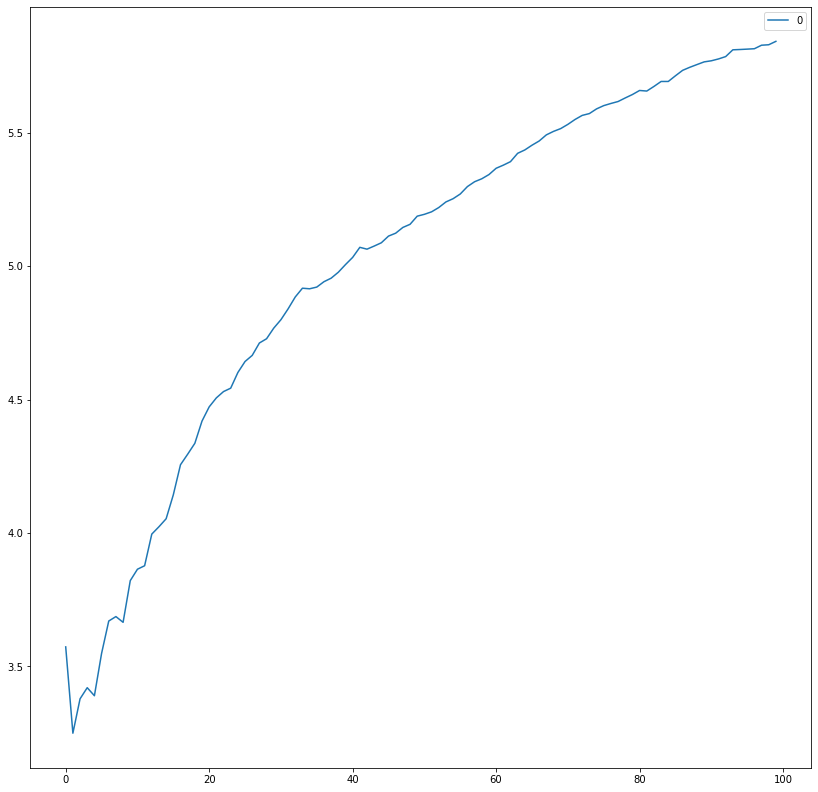

In [310]:
#plotting the rmse values against k values

curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot(figsize=(14, 14))

In [311]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train,y_train)
print("bets param", model.best_params_)


bets param {'n_neighbors': 2}


In [319]:
# y_pred = model.predict(X_test_norm)
# metrics.accuracy_score(y_test, y_pred)
model.score(X_test_norm, y_test)

-1.2065505643047274

In [314]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
tree = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
tree.fit(X_norm, y_train)

DecisionTreeRegressor(random_state=0)

In [315]:
regressor.score(X_test_norm, y_test)

0.4227353376236602

In [316]:
from sklearn.svm import SVR
svm = SVR(kernel = 'rbf')
svm.fit(X_norm, y_train)

SVR()

In [317]:
svm.score(X_test_norm, y_test)

0.48353709191136174

In [320]:
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
logisticRegr.fit(X_norm, y_train)

ValueError: Unknown label type: 'continuous'

In [321]:
# MLP
# Import MLPClassifer 
from sklearn.neural_network import MLPClassifier

# Create model object
clf = MLPClassifier(hidden_layer_sizes=(6,5),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01)

# Fit data onto the model
clf.fit(X_norm,y_train)

ValueError: Unknown label type: (array([26.91075147, 21.51237585, 20.51583549, 18.08173018, 12.79330797,
       11.31902132,  7.12825513,  8.20371762,  3.61673785, 14.91836787,
       19.24127694,  8.55289183,  4.39238986, 25.24834691, 10.52384715,
        8.42127301,  4.60417535,  5.00673951,  8.80207767,  3.60851182,
       12.16789533, 12.40320919, 16.51485387, 17.36496563,  8.91501638,
       17.96717728,  8.60608471, 24.48481777,  7.50605707, 15.00235615,
        3.80046675, 18.93471161, 10.91361627, 29.31676635,  6.07456519,
        3.82693581,  6.71006363,  2.85176757,  8.79624235,  8.8062548 ,
        6.24458116,  5.75007317,  7.15555952, 19.96722435,  1.4351934 ,
       24.94162169,  4.36357205, 21.16335943, 21.00672474, 31.15188151,
        5.24514197,  4.27487056,  8.11923549, 21.48393612, 23.87423142,
       11.14643373,  8.10763083,  5.33807927, 13.73081943,  4.33988958,
        8.98885423,  6.11890612,  8.95326175, 17.83305496, 14.884016  ,
       19.72002413,  6.23888916, 17.16140688,  7.673342  ,  9.93726447,
       23.3681917 , 14.58372801, 16.68190973, 17.7507422 , 11.70629031,
       20.37091789,  3.07517667,  8.4595446 , 21.71552142,  5.5797296 ,
        6.28204454, 39.42601598,  6.87372263, 10.90915152,  7.6278274 ,
       12.55033894, 16.32351587,  9.88722799,  2.24562609, 21.1006873 ,
       10.86144033,  4.00523919,  6.77920704, 11.04089953, 17.06116807,
        4.49070845,  1.82603863, 14.69644875, 17.34603084, 13.24091153,
        7.10144908,  5.45503226,  6.52175795, 15.99341653, 16.92831689,
        5.43353697,  6.5139214 , 22.17906102,  8.66515071, 15.3474317 ,
        5.30454148, 35.92854776,  4.0655428 , 28.93193423, 15.19217826,
       21.02259135,  6.34267181,  8.17305408,  2.4689947 , 11.42796255,
       19.64270063, 14.76750827, 29.85374272,  5.70764093, 15.25260792,
        6.27554293, 10.0406455 , 24.7020161 , 17.61545399,  2.34825624,
        9.14605118, 22.78141665, 19.28919641,  5.16260542,  3.3137014 ,
        5.65415841,  6.49473305,  7.86564442,  4.29769093, 19.09375163,
       12.06287679, 20.2248501 , 15.64956731, 11.60154414, 27.68908018,
        8.79378546,  4.45930555, 22.88466451,  7.38066544, 12.16030196,
        2.14123344, 16.66054423,  2.95379273,  6.75882501,  1.59605945,
       18.27819712,  5.08522194, 20.29083125,  4.70284606,  7.45037882,
        7.48045231, 14.53177955, 12.93618325,  3.95828286,  3.59340185,
        5.73259897, 10.82374295,  8.4763937 ,  8.35421999, 13.1588767 ,
        4.30836953, 11.02369188,  9.67692058, 29.22879415, 18.78486781,
       12.14733765,  5.19780961,  8.67402341, 16.99991032,  3.93522222,
        4.69114705, 19.97377381, 41.5169302 , 21.16799667, 11.04649507,
       12.68083987,  6.93215034, 11.98796706, 19.56868131, 11.02311343,
       10.6627866 ,  8.49299246, 11.14246248, 10.16779741,  8.87709907,
        3.94286481,  7.13341206, 34.52413599,  5.7045798 , 22.86156691,
       19.10990627,  8.49235616, 39.51220574, 32.93630434,  4.42560197,
       14.10385226, 20.3529041 ,  4.81911159, 22.00292411, 19.33172291,
       14.68035237,  4.39585884, 35.70649176, 16.86951391,  5.4786634 ,
       15.89467554,  6.70961985, 18.19554661, 19.15533075,  4.06337005,
        5.74693066,  9.26257488,  5.65586299, 19.01338821,  8.08460656,
       19.46831671,  9.38463392,  4.78548827, 15.54632161,  6.65700452,
       12.90353745, 10.34940201, 23.335712  , 19.9020572 , 12.34476304,
        3.63864791, 18.35367091, 23.09727211, 16.9301802 , 15.80144787,
       10.3176908 , 17.98631576, 17.8913182 , 16.33677575,  5.70950538,
       14.33585714,  5.01537666, 16.39984054, 37.70888969,  5.32594279,
       20.41086516,  7.26864276, 10.3692288 ,  6.66748835, 37.44331432,
        3.42575472, 16.10518058, 21.80723485, 20.24083551,  6.90405199,
       13.0620733 , 22.27542437, 11.60902535, 20.43893805, 14.01463217,
       19.88523122,  9.69984074, 15.90049889,  7.49675744,  6.04245624,
       23.98018169, 22.04907664,  4.50702193, 16.25536014, 19.96722363,
        7.01787638,  7.39905927,  4.78015917,  4.52254874,  3.49667394,
        2.43599113,  4.42866639, 11.39921649, 12.63702187, 15.92009933,
        9.27320202,  9.87368773,  5.85732942,  6.2552074 , 14.63372754,
        9.98893789,  1.81335698,  8.77747297, 11.91103266,  6.75843607,
        6.25830666,  6.9158725 , 10.3183626 , 18.85271942,  5.5317276 ,
        4.53881013,  5.93858748,  2.66212815, 15.32676471,  9.4599013 ,
       24.15005843,  3.32484093, 12.65773381, 36.26703663,  6.5594258 ,
        8.93793599,  9.77693179,  7.86998651,  3.45802217, 15.80169675,
       17.54596127,  9.03875534,  6.84237418, 15.81807599, 13.77832041,
        3.72115196, 26.73660013,  8.30748518, 26.49544263,  4.22971352,
       35.54839143,  4.95213577,  5.11907958,  3.20376939,  5.73151141,
       12.33167153,  1.60934158, 15.98713026,  4.89919928, 11.60716368,
        6.94046591, 20.10197274,  7.22869595, 17.0901198 , 17.34910539,
       16.31053731, 16.40767867, 23.64821654,  4.45260717, 44.60848309,
        1.72894971, 19.63776187, 35.28950111, 20.50702295,  3.12128156,
       25.68650462,  8.08100228, 29.16139456, 20.69429852, 11.00831742,
        4.30315498, 14.68054196, 20.20233842, 13.65344781, 36.00652562,
       20.77934164,  6.12435683, 26.39278431, 19.49564041,  9.26915871,
        6.4046896 , 28.20242992,  6.50759441, 12.07483021,  6.23804544,
        2.49851673, 21.73661251, 11.39840829,  2.28074578, 19.72609185,
       10.09697625,  7.02739523, 12.2846144 , 10.51583268,  5.42649185,
        6.48069012, 19.87659912,  5.60264447,  9.31305337,  6.56004892,
       37.23885594, 22.03935782, 17.89505291,  4.79346527,  6.59047176,
       16.50844572, 12.15584703, 18.80902153,  3.45913591,  7.58516985,
        9.44680634, 22.31560525, 33.25268585, 12.51214257,  6.6474797 ,
       15.22366992,  5.49727867, 20.71917326,  3.97219627,  5.25419027,
       13.50420207,  7.86090262,  7.40772372, 10.7257838 , 14.40748307,
       11.22857918,  2.57948112, 13.51326729,  9.137062  ,  3.26296099,
       19.78516135, 18.02447182, 16.41166605,  7.21642702,  5.46087487,
        6.47703029,  9.39039205,  1.4427457 ,  7.4990251 , 10.97931101,
        9.49963343,  7.66869001, 10.30356639,  5.43786208,  7.57478596,
       16.39284262,  5.72366737,  8.44711569,  4.42231523,  2.49711416,
        1.56353502, 25.73804591,  2.51017397, 21.17082335,  6.94989049,
       13.53456085,  6.75462349, 13.14006824, 15.01730512, 10.1351366 ,
        6.25120228, 14.07100912, 51.44038802,  6.19890552, 11.89909113,
        5.66739678,  6.26514345,  4.99619832,  9.95631416, 17.25213422,
       10.46781147,  5.05559898,  9.85485591, 13.59266097,  4.35164635,
       36.48767665, 10.16856175,  6.42061186,  5.84378593,  7.06904023,
       18.08572908, 19.22636546,  4.72076384, 20.55569769, 17.9925373 ,
       10.16825192, 25.3938314 , 11.88593893, 10.92067415, 12.99741254,
        5.83668749,  9.46301156,  8.74493455,  2.35312498,  6.5761173 ,
       10.45560352, 24.80501655,  3.1026495 , 34.44996967,  3.77191212,
       14.66632872, 13.74412942,  7.95888156, 10.48939595,  5.25831661,
       18.37253146,  6.79162831, 37.3959357 , 14.19728843, 15.28131378,
        6.14325075,  6.6702963 ,  6.60080992, 11.17933317, 10.67865135,
        8.06104273,  4.41543692,  5.11160642,  6.30385758,  4.04880277,
        5.549657  ,  9.54101921,  6.90095551,  6.08979291,  7.32086739,
       14.47332719,  5.72948178, 12.74144595,  2.8271007 ,  8.15365997,
        6.2458004 ,  7.73360952, 18.02176277,  5.66052256,  4.43254633,
       18.53843413,  4.09967809,  1.77757399, 20.25329211, 36.05774911,
        5.4194578 ,  4.42541623, 21.0872728 ,  6.9492998 ,  8.22999708,
       16.36646753, 37.44498332, 11.28255822, 12.32270981,  4.78947753,
        3.9409416 , 24.87283717,  5.93563199,  5.37236013, 32.80128676,
       21.31827718, 12.49568502, 27.09254283,  4.88554097, 16.50597668,
        4.38356898,  5.6782511 , 45.92346335,  1.93509374, 12.26161813,
       20.82383332, 25.76259084, 18.52251666, 12.10494722, 13.46487279,
        9.06950625, 16.53553493, 19.56762462,  8.25036277,  4.75072256,
        6.17861584, 12.24922813,  6.5449828 , 10.14830401, 37.29851827,
       15.85200216, 11.19100953, 31.30319798, 20.91247348,  6.61807887,
       25.79977836, 38.34291688,  6.76607632, 12.779454  ,  6.35338298,
        6.02224366,  1.57517008, 10.36715769, 21.40722352,  7.57250114,
        6.8456615 , 38.3944832 ,  1.54257784,  8.35110592, 31.56799491,
       11.19698503,  6.07083594,  7.53430655, 11.53260044,  3.13136906,
        8.94213109,  7.50953343,  6.69576774,  4.77866181,  1.49340422,
        6.38431856,  4.81919396, 20.41262508,  5.2557076 , 20.25899898,
        5.20811194, 27.93714267, 19.59459539, 14.95398983,  7.62415734,
        6.83691202, 11.68216258, 10.88240101,  6.51653214,  7.78420593,
       10.39529531,  1.61711702, 12.256417  ,  6.56608394, 23.02037235,
        7.18403488,  8.46224029, 12.29354555,  7.69406689, 17.26686381,
       11.24101936, 13.27192646,  7.94866586, 15.35322729,  4.85512018,
        6.71067308,  4.58157424,  5.42842456,  6.55506497,  7.83811992,
        3.59853077,  1.53298466, 50.86500563,  5.54563289, 22.80517727,
       26.26480882, 23.40085045, 13.58554906, 31.83422919,  1.59520604,
        7.33627246, 15.83644731,  4.86155897, 19.77800433, 11.15083538,
       13.45296288,  3.53176857,  9.65184557, 20.39591032,  5.06666523,
       11.95702242,  3.92427263, 11.24104919, 10.50003041,  7.10127177,
        1.59126708,  5.14615308,  1.46217898, 15.01402057,  5.87256065,
       14.49125908,  1.87433539, 10.31745961,  6.91140827,  1.58199847,
        9.01518548, 16.01639758, 16.44951159, 16.82453696, 10.20310994,
        5.58708911,  7.3687277 , 23.16134616,  5.33785485,  2.85436417,
       21.71255692,  8.18905627,  6.38372295, 30.87978516, 41.6539628 ,
       22.29002268,  9.88110018,  4.8015423 , 10.92191973, 38.47699556,
       38.06091427, 18.93082721,  6.80288544, 14.23681877, 11.13393956,
       16.42851846,  5.80104141,  5.05870937,  5.40465322, 29.70465939,
       19.24448269, 15.30255035, 20.89081678, 15.94001873, 17.1989786 ,
       15.11234867,  6.70415834, 21.44763444,  5.08624742, 20.38420087,
       18.80770895, 37.3829205 , 12.71289384,  4.92224687,  2.615999  ,
        5.84109053,  5.68516411,  1.57947224,  5.75909584, 10.12014745,
       20.02582662, 21.06402752, 20.81825658, 10.52641159,  8.25451298,
        7.73154929,  8.81774403,  6.70976941, 12.80763458,  6.42987294,
       17.13788221, 17.49077096,  3.61123106,  7.01640864, 20.37066466,
       19.0233633 , 20.09741941,  7.69853053,  4.73085248,  7.64828494,
        4.39383795,  9.18337828,  5.52368483,  5.47531894, 17.49742778,
       27.15479335, 19.92964951,  8.8612898 ,  5.13438449, 20.94487894,
       15.24538159, 10.43810332,  5.35744259,  4.65397837, 14.33612619,
       12.90516455,  6.45159481, 11.86819777, 29.33050556, 16.69285552,
        6.28653791,  6.84034118,  3.58160634,  5.88236456,  9.62142932,
       39.76822598,  6.73293576, 20.08123064,  6.45326002, 36.91089091,
        1.77571115, 11.54603938, 14.67353282,  6.71665672, 16.97104039,
        3.52810903,  7.57134903, 16.44002785, 16.12589132,  4.2248338 ,
        6.3438086 ,  7.24143882,  9.6207703 ,  1.64175321, 18.28651217,
       28.66068865, 16.25045665,  4.62416334,  2.59537061, 12.55729459,
        8.16897391,  6.29708357,  8.15530127,  6.02999429, 14.60915766,
       14.67967121, 16.36602858, 17.70486956, 23.62921683,  9.38608681,
       23.23105135, 16.92156156,  1.4401514 ,  2.07949727, 10.31566059,
        2.08405791, 14.48971841,  5.18610705,  4.13041847,  5.41911316,
        6.21818447, 12.44027976,  3.52086819,  6.44078265, 10.56055189,
        6.31707801, 11.29008264,  4.62683452, 31.873928  ,  7.76351956,
       10.52213152,  1.42386845,  7.04885492, 17.3518816 , 21.0466984 ,
       11.119143  , 25.03302878,  5.2441972 ,  7.0364274 , 24.99850032,
        2.79957261, 10.64468858, 14.39734665, 18.44837422, 16.69299298,
       21.34936693,  5.47243835, 13.67211878,  8.29066018, 22.84722313,
       20.07232163,  5.25616296, 11.90107505, 19.78649896,  4.86699292]),)